In [1]:
from sklearn.datasets import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(d,axis=0), np.max(d,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")


# Ejercicio 1: API `sklearn`

Organiza el código de las notas, en la aproximación basada en probabilidad, en una clase siguiendo el API de `sklearn`. Para esto:

- La función `fit` calcula el $\theta$ óptimo. Observa que a la función le llegan los datos originales en una matrix $\mathbf{R}^{m \times n}$, tendrás que añadirles una columna de 1's.
- El $\theta$ óptimo se guarda en la variable de instancia `self.theta`
- La función `predict` tendrá que añadirle una columna de 1's a los datos que reciba y usar `self.theta`

In [2]:
def LR(**args): # hack for inspect to work with classes
    from scipy.optimize import minimize
    import numpy as np
    
    class LR_class:
        def fit(self, X, y):
            X = np.hstack((np.ones((len(X),1)), X))
            
            def cost(t):
                return -np.sum(np.log(self.g(X.dot(t)))*y+np.log(1-self.g(X.dot(t)))*(1-y))
            
            def grad(t):
                return 2*X.T.dot(self.g(X.dot(t))-y)/len(X)
            
            r = minimize(cost, np.zeros(X.shape[1]), jac=grad, method="BFGS")
            self.theta = r.x 

        def predict(self, X):
            X = np.hstack((np.ones((len(X),1)), X))
            return (self.g(X.dot(self.theta))>0.5)*1

        def g(self, X):
            return 1/(1+np.exp(-X))
        
    return LR_class(**args)


comprueba tu código

[[ 0.78030254  0.72335743]
 [ 1.82516837  0.29302123]
 [ 0.63333602 -0.25961592]
 [-0.77063347 -0.02121573]
 [ 0.92992092 -0.33541659]
 [ 0.14399128  1.67337581]
 [ 1.4401308  -0.43558105]
 [ 1.10445433 -0.43070833]
 [-0.89362518  0.53840388]
 [-0.15120273  0.60053888]]
predictions    [0 1 1 0 1 0 1 1 0 0]
actual classes [0 1 1 0 0 0 1 1 0 1]


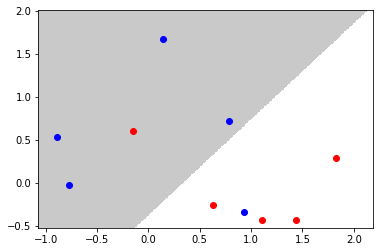

In [5]:
(d,c) = make_moons(n_samples=10, noise=0.2)
print d
lr = LR()
lr.fit(d,c)
print "predictions   ", lr.predict(d)
print "actual classes", c
plot_2Ddata_with_boundary(lr.predict, d, c)

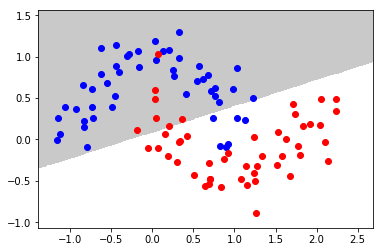

In [6]:
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
d,c = data[:,:2], data[:,2]
lr = LR()
lr.fit(d,c)
plot_2Ddata_with_boundary(lr.predict, d, c)

# Ejercicio 2: Métrica de desempeño

completa el método `score` para que:

- llame al método `predict``
- calcule el porcentaje de aciertos de predicción con respecto a `y`

In [7]:
def LR(**args): # hack for inspect to work with classes
    from scipy.optimize import minimize
    import numpy as np
    
    class LR_class:
        def fit(self, X, y):
            X = np.hstack((np.ones((len(X),1)), X))
            def cost(t):
                return -np.sum(np.log(self.g(X.dot(t)))*y+np.log(1-self.g(X.dot(t)))*(1-y))
            def grad(t):
                return 2*X.T.dot(self.g(X.dot(t))-y)/len(X)

            r = minimize(cost, np.zeros(X.shape[1]), jac=grad, method="BFGS")
            self.theta = r.x        

        def predict(self, X):
            X = np.hstack((np.ones((len(X),1)), X))
            return (self.g(X.dot(self.theta))>0.5)*1

        def g(self, X):
            return 1/(1+np.exp(-X))

        def score(self, X,y):
            return np.sum(self.predict(X)==y)*1./len(X)
        
    return LR_class(**args)


comprueba tu código. el porcentaje de acierto debería de ser del 87%

0.87


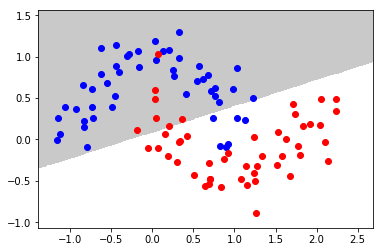

In [8]:
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
d,c = data[:,:2], data[:,2]
lr = LR()
lr.fit(d,c)
print lr.score(d,c)
plot_2Ddata_with_boundary(lr.predict, d, c)

# Ejercicio 3: Función de máxima verosimilitud (MLE) en `sympy`

Completa la función siguiente para que devuelva la siguiente expresión en `sympy` usando el dataset cargado en `X` e `y`, para el caso en el que $\theta \in \mathbb{R}^3$

$$ - \sum_{i=0}^{m-1}y^{(i)} log(g(\mathbf{x}^{(i)}\theta))+(1-y^{(i)}) log(1-g(\mathbf{x}^{(i)}\theta))$$

Observa que es el **negativo** del MLE, ya que queremos maximizarlo.

Dentro del bucle `for` puedes usar `X[i].dot(t)` para implementar la expresión $\mathbf{x}^{(i)}\theta$, y también `y[i]` para $y^{(i)}$. Recuerda que $g(z) = \frac{1}{1+e^{-z}}$. Para la función exponencial usa `sympy.exp` (no uses `np.exp`)

Realiza el ejercicio de forma análoga a las notas de la lección para el caso de la aproximación basada en el coste.

In [9]:
def MLE():
    import numpy as np
    import sympy
    
    data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
    X, y = data[:,:2], data[:,2]
    X = np.hstack((np.ones((len(X),1)), X))

    t0, t1, t2 = sympy.symbols("theta_0 theta_1 theta_2")
    t = np.array([t0,t1,t2])
    expr = 0
    for i in range(len(X)):

        g = 1/(1+sympy.exp(-(X[i].dot(t))))
        expr += sympy.log(g)* y[i]+sympy.log(1-g)*(1-y[i])
    return -expr


comprueba tu código. el MLE de $\theta=[0,0,0]$ debe de ser 69.31 aprox.

In [10]:
import sympy

t0, t1, t2 = sympy.symbols("theta_0 theta_1 theta_2")
t = np.array([t0,t1,t2])

s_cost = sympy.lambdify([t], MLE(), "numpy")
s_cost([0,0,0])

69.31471805599459

# Ejercicio 4: Derivadas del MLE evaluables en Python

fíjate como se obtiene una función evaluable Python del MLE que definiste anteriormente. En particular, observa como en esta ocasión el argumento de `lambdify` es el vector `t`.

In [11]:
import sympy

t0, t1, t2 = sympy.symbols("theta_0 theta_1 theta_2")
t = np.array([t0,t1,t2])

s_cost = sympy.lambdify([t], MLE(), "numpy")
s_cost([0,0,0])

69.31471805599459

siguiendo este ejemplo, completa la siguiente función para que devuelva la función gradiente evaluable en Python de la expresión `sympy` pasada como argumento, de forma análoga a las notas de la lección para el caso de la aproximación basada en el coste, para el caso en el que $\theta \in \mathbb{R}^3$

In [12]:
def grad_MLE(expr):
    import numpy as np
    import sympy

    t0, t1, t2 = sympy.symbols("theta_0 theta_1 theta_2")
    t = np.array([t0,t1,t2])  
    
    expr_dt0 = expr.diff(t0)    # dejar este al estudiante
    expr_dt1 = expr.diff(t1)
    expr_dt2 = expr.diff(t2)
    
    d0 = sympy.lambdify([t], expr_dt0, "numpy")
    d1 = sympy.lambdify([t], expr_dt1, "numpy")
    d2 = sympy.lambdify([t], expr_dt2, "numpy")

    s_grad = lambda x: np.array([d0(x), d1(x), d2(x)])
    
    return s_grad

import urllib, inspect
src4 = urllib.quote_plus(inspect.getsource(grad_MLE))

comprueba tu código:
   
- en $\theta=[ 0.39,  1.35, -4.28]$ el gradiente debería de ser aprox [0,0,0] 
- en $\theta=[0, 0,0]$ el gradiente debería de ser [0, -25.5, 17] aprox.
- si usas el minimizador con tus funciones, el valor de $\theta$ donde el gradiente es [0,0,0]

In [13]:
import sympy
import numpy as np
from scipy.optimize import minimize

t0, t1, t2 = sympy.symbols("theta_0 theta_1 theta_2")
t = np.array([t0,t1,t2])  

MLE_expression = MLE()
s_cost = sympy.lambdify([t], MLE_expression, "numpy")
s_grad = grad_MLE(MLE_expression)
print s_grad([ 0.39235424,  1.35433531, -4.27952082])
print s_grad([0,0,0])

r = minimize(s_cost, np.zeros(len(t)), jac=s_grad, method="BFGS")
r

[-5.58210443e-06 -3.51739547e-06 -6.79990622e-06]
[  0.     -25.493   16.9995]


      fun: 31.989414572892333
 hess_inv: array([[ 0.17836417, -0.06390659, -0.19466736],
       [-0.06390659,  0.14052233, -0.03683371],
       [-0.19466736, -0.03683371,  0.87162649]])
      jac: array([-1.41321930e-07,  5.89599719e-07,  8.62622038e-07])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 14
     njev: 16
   status: 0
  success: True
        x: array([ 0.3923533 ,  1.35433532, -4.27951474])